In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta

# Preprocessing and clustering
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import dendrogram, linkage

# Visualization
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

### Part 01: Data preparation and feature engineering

#### 01) Clean the data
#### 02) Generate customer-level features

In [11]:
# Load the dataset
def load_data():
   
    try:
        df = pd.read_csv('Copy of Online Retail.csv', encoding='ISO-8859-1')
        print("Dataset loaded successfully!")
        return df
    except:
        print("Please download the dataset from UCI repository first.")
        return None

# Data cleaning and preprocessing
def preprocess_data(df):
    data = df.copy()
    
    # Remove records with missing CustomerID
    data = data[data['CustomerID'].notna()]
    
    # Filter for United Kingdom only
    data = data[data['Country'] == 'United Kingdom']
    
    # Remove cancelled orders (InvoiceNo starting with 'C')
    data = data[~data['InvoiceNo'].astype(str).str.startswith('C')]
    
    # Calculate total price
    data['TotalPrice'] = data['Quantity'] * data['UnitPrice']
    
    # Convert InvoiceDate to datetime
    data['InvoiceDate'] = pd.to_datetime(data['InvoiceDate'])
    
    return data

# RFM Feature Engineering
def calculate_rfm(data):
    # Set reference date (one day after the last invoice date)
    max_date = data['InvoiceDate'].max() + timedelta(days=1)
    
    # Calculate RFM values
    rfm = data.groupby('CustomerID').agg({
        'InvoiceDate': lambda x: (max_date - x.max()).days,  # Recency
        'InvoiceNo': 'nunique',  # Frequency
        'TotalPrice': 'sum'  # Monetary
    }).reset_index()
    
    # Rename columns
    rfm.columns = ['CustomerID', 'Recency', 'Frequency', 'Monetary']
    
    return rfm

# Load and preprocess data
df = load_data()
print(df.shape)
if df is not None:
    data = preprocess_data(df)
    rfm = calculate_rfm(data)
    
    # Display first few rows of RFM data
    print("RFM Data Overview:")
    print(rfm.head())
    
    # Basic statistics
    print("\nRFM Data Statistics:")
    print(rfm[['Recency', 'Frequency', 'Monetary']].describe())

Dataset loaded successfully!
(541909, 8)
RFM Data Overview:
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12747.0        2         11   4196.01
2     12748.0        1        210  33719.73
3     12749.0        4          5   4090.88
4     12820.0        3          4    942.34

RFM Data Statistics:
           Recency    Frequency       Monetary
count  3921.000000  3921.000000    3921.000000
mean     92.188472     4.246111    1863.910113
std      99.528995     7.205750    7481.922217
min       1.000000     1.000000       0.000000
25%      18.000000     1.000000     300.040000
50%      51.000000     2.000000     651.820000
75%     143.000000     5.000000    1575.890000
max     374.000000   210.000000  259657.300000


#### 03) Standaedize the RFM data before clustering
#### 04) Visualize the RFM distribution

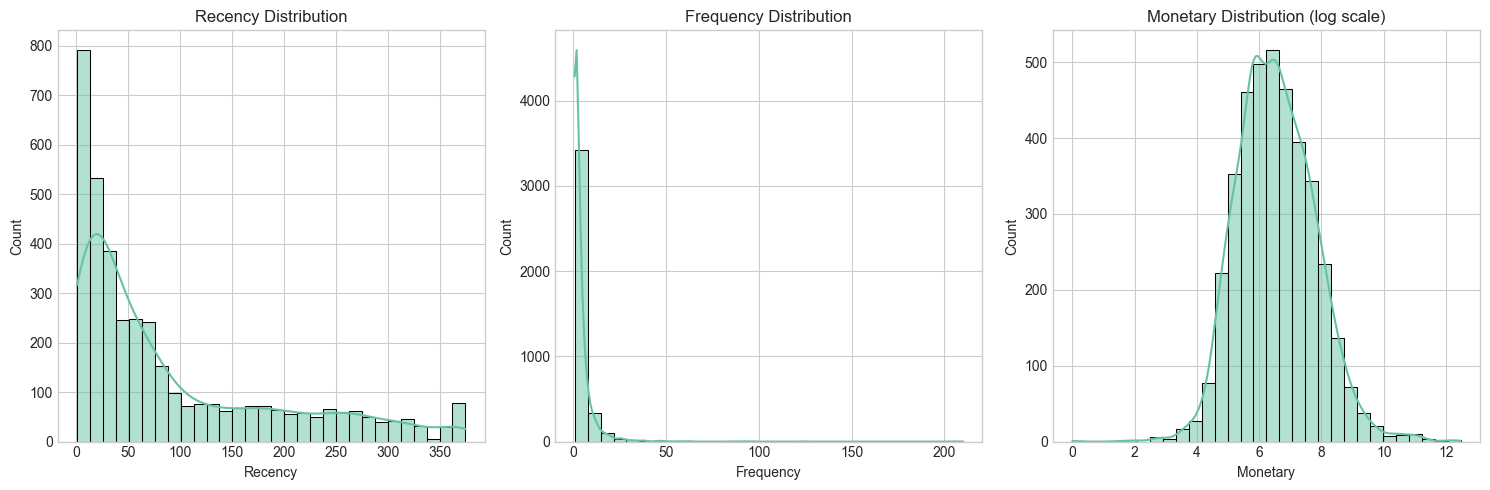

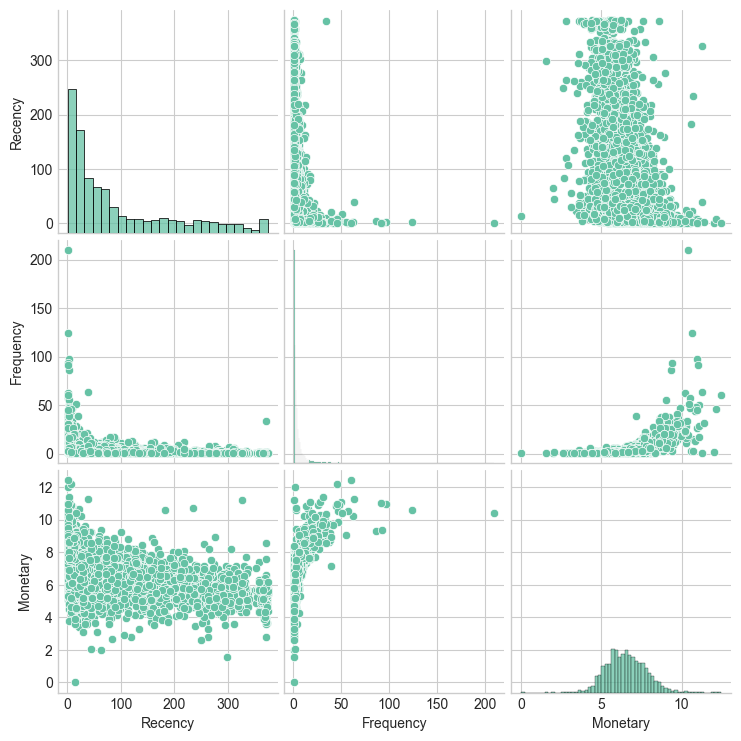

In [ ]:

def standardize_rfm(rfm):
    # Initialize scaler
    scaler = StandardScaler()
    
    # Select only the RFM columns
    rfm_scaled = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary']])
    
    # Create a new DataFrame with scaled values
    rfm_scaled = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])
    
    return rfm_scaled, scaler

# Standardize the data
rfm_scaled, scaler = standardize_rfm(rfm)

# Visualize RFM distributions
def plot_rfm_distributions(rfm):
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Recency distribution
    sns.histplot(rfm['Recency'], bins=30, kde=True, ax=axes[0])
    axes[0].set_title('Recency Distribution')
    
    # Frequency distribution
    sns.histplot(rfm['Frequency'], bins=30, kde=True, ax=axes[1])
    axes[1].set_title('Frequency Distribution')
    
    # Monetary distribution (log scale for better visualization)
    sns.histplot(np.log1p(rfm['Monetary']), bins=30, kde=True, ax=axes[2])
    axes[2].set_title('Monetary Distribution (log scale)')
    
    plt.tight_layout()
    plt.savefig('rfm_distributions.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot distributions
plot_rfm_distributions(rfm)

# Pairplot for RFM features
def plot_rfm_pairplot(rfm):
    # Apply log transformation to Monetary for better visualization
    rfm_plot = rfm.copy()
    rfm_plot['Monetary'] = np.log1p(rfm_plot['Monetary'])
    
    sns.pairplot(rfm_plot[['Recency', 'Frequency', 'Monetary']])
    plt.savefig('rfm_pairplot.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot pairplot
plot_rfm_pairplot(rfm)

### Part 02: Apply and Analyze clustering methods

#### 2.1) K-Means clustering

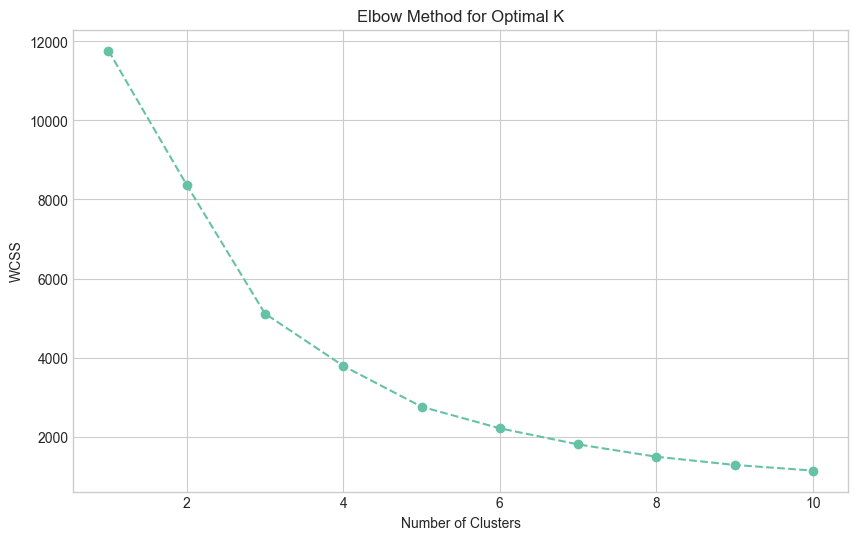

Optimal number of clusters (elbow point): 3
K-Means Cluster Summary:
         Recency_Mean  Recency_Std  Frequency_Mean  Frequency_Std  \
Cluster                                                             
0               40.74        34.78            4.72           5.21   
1              243.78        67.49            1.59           1.49   
2               19.39        67.33           59.96          44.52   

         Monetary_Mean  Monetary_Std  Count  Percentage  
Cluster                                                  
0              1784.42       3036.35   2902       74.01  
1               487.60       1499.03    996       25.40  
2             71494.41      59175.63     23        0.59  


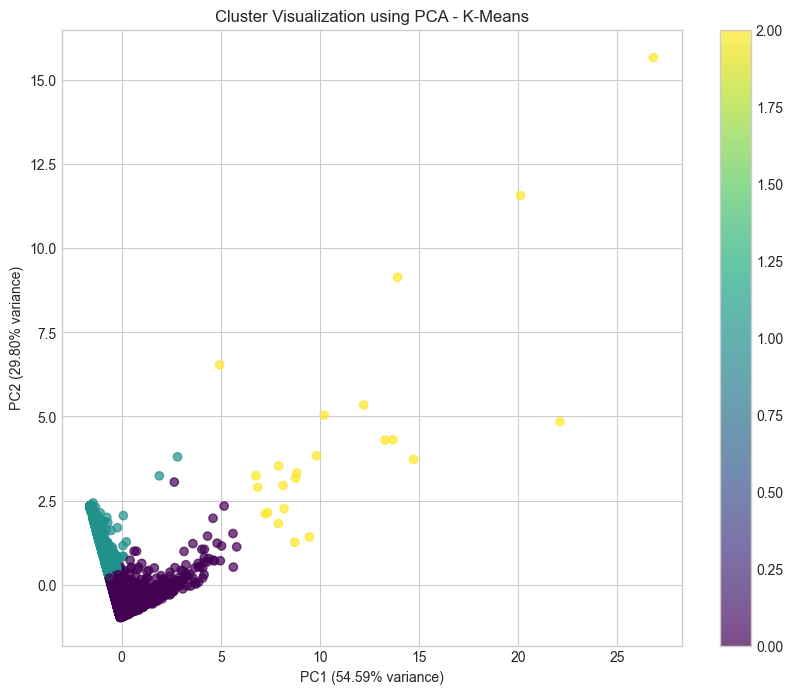

In [6]:
# K-Means Clustering with Elbow Method
def kmeans_elbow_method(rfm_scaled, max_clusters=10):
    wcss = []  # Within-Cluster Sum of Squares
    
    for i in range(1, max_clusters+1):
        kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
        kmeans.fit(rfm_scaled)
        wcss.append(kmeans.inertia_)
    
    # Plot the elbow curve
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, max_clusters+1), wcss, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.title('Elbow Method for Optimal K')
    plt.savefig('kmeans_elbow.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return wcss

# Apply elbow method
wcss = kmeans_elbow_method(rfm_scaled)

# Determine optimal k (using the elbow point)
def find_elbow_point(wcss):
    # Calculate the difference in WCSS
    deltas = np.diff(wcss)
    # Calculate the difference of differences
    deltas2 = np.diff(deltas)
    # The elbow point is where the second difference is maximum
    elbow_point = np.argmax(deltas2) + 2  # +2 because we took two differences
    
    return elbow_point

optimal_k = find_elbow_point(wcss)
print(f"Optimal number of clusters (elbow point): {optimal_k}")

# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(rfm_scaled)

# Add cluster labels to the original RFM data
rfm_kmeans = rfm.copy()
rfm_kmeans['Cluster'] = kmeans_labels

# Analyze cluster characteristics
def analyze_clusters(rfm_with_clusters):
    cluster_summary = rfm_with_clusters.groupby('Cluster').agg({
        'Recency': ['mean', 'std'],
        'Frequency': ['mean', 'std'],
        'Monetary': ['mean', 'std'],
        'CustomerID': 'count'
    }).round(2)
    
    cluster_summary.columns = ['Recency_Mean', 'Recency_Std', 
                               'Frequency_Mean', 'Frequency_Std', 
                               'Monetary_Mean', 'Monetary_Std', 
                               'Count']
    
    # Calculate percentage of customers in each cluster
    cluster_summary['Percentage'] = (cluster_summary['Count'] / cluster_summary['Count'].sum() * 100).round(2)
    
    return cluster_summary

# Get cluster summary for K-Means
kmeans_summary = analyze_clusters(rfm_kmeans)
print("K-Means Cluster Summary:")
print(kmeans_summary)

# Visualize clusters using PCA
def plot_clusters_pca(rfm_scaled, labels, algorithm_name):
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(rfm_scaled)
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'Cluster': labels
    })
    
    plt.figure(figsize=(10, 8))
    scatter = plt.scatter(plot_df['PC1'], plot_df['PC2'], c=plot_df['Cluster'], 
                         cmap='viridis', alpha=0.7)
    plt.colorbar(scatter)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title(f'Cluster Visualization using PCA - {algorithm_name}')
    plt.savefig(f'pca_{algorithm_name.lower().replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return pca_result

# Visualize K-Means clusters
pca_kmeans = plot_clusters_pca(rfm_scaled, kmeans_labels, "K-Means")

#### 2.2) Hierarchical Clustering (AGNES)

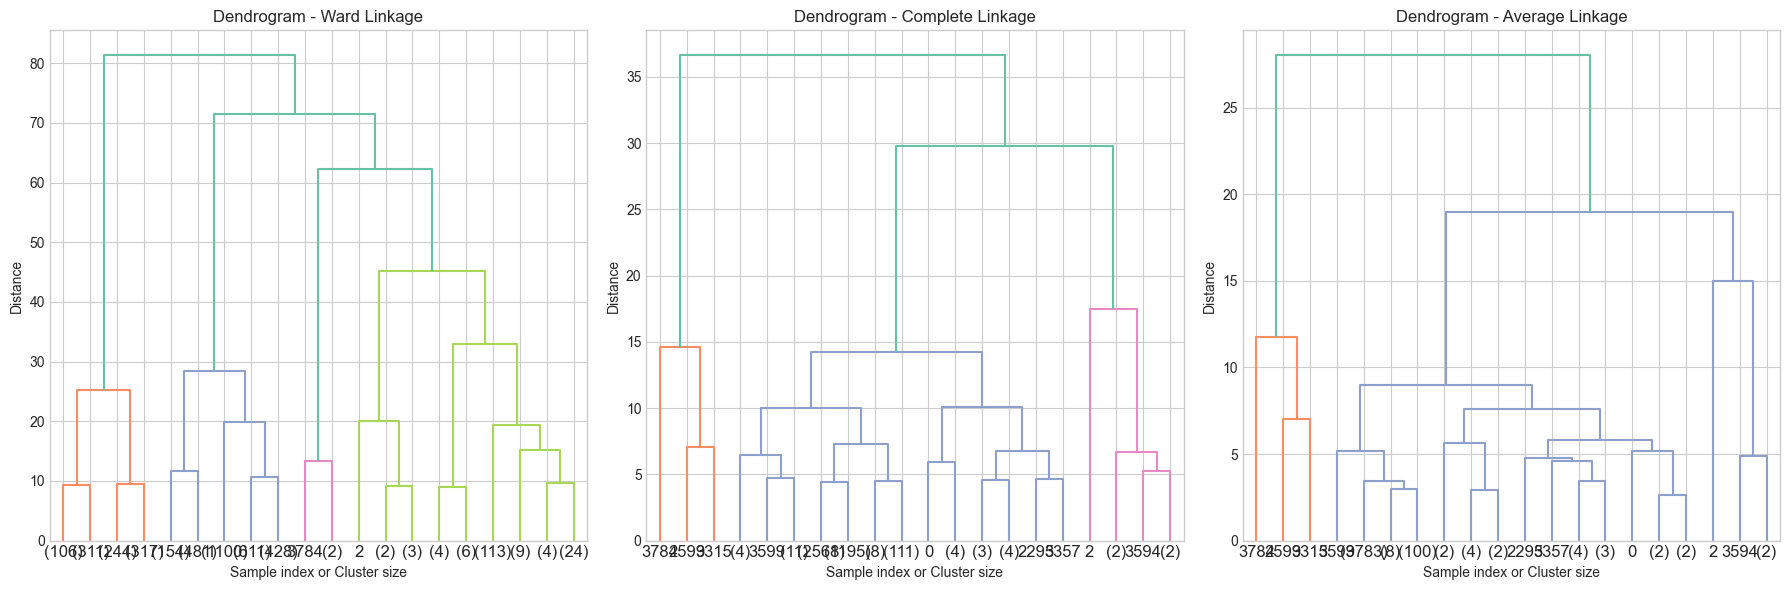

Agglomerative Clustering Summary:
         Recency_Mean  Recency_Std  Frequency_Mean  Frequency_Std  \
Cluster                                                             
0               14.53        43.60           26.95          22.04   
1              245.38        66.62            1.56           1.10   
2               42.91        35.38            3.81           3.07   

         Monetary_Mean  Monetary_Std  Count  Percentage  
Cluster                                                  
0             19084.64      30923.33    169        4.31  
1               436.18        518.03    978       24.94  
2              1318.14       1419.60   2774       70.75  


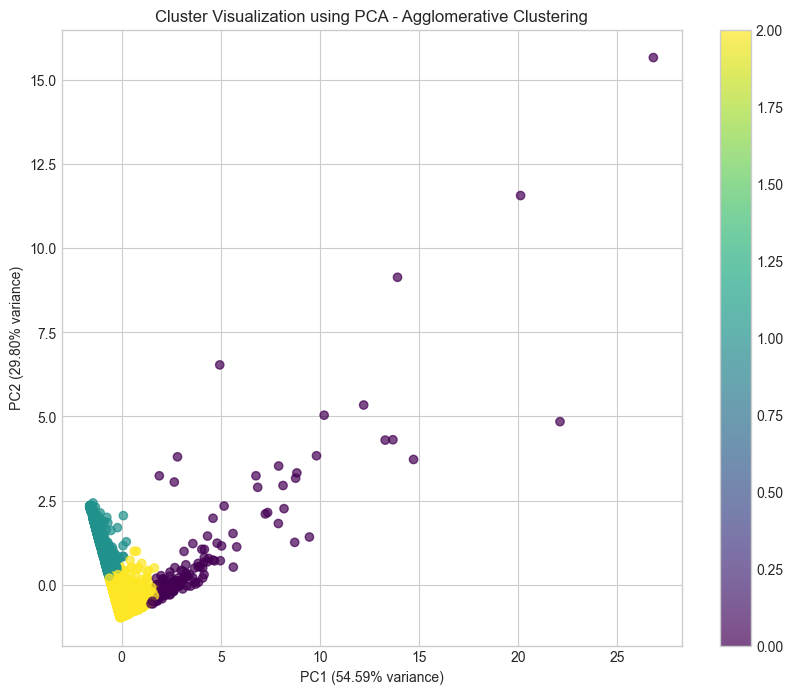

In [7]:
# Hierarchical Clustering with different linkage methods
def hierarchical_clustering_analysis(rfm_scaled, methods=['ward', 'complete', 'average']):
    # Create subplots
    fig, axes = plt.subplots(1, len(methods), figsize=(18, 6))
    
    for i, method in enumerate(methods):
        # Calculate the linkage matrix
        Z = linkage(rfm_scaled, method=method)
        
        # Plot dendrogram
        dendrogram(Z, ax=axes[i], truncate_mode='lastp', p=20, show_leaf_counts=True)
        axes[i].set_title(f'Dendrogram - {method.capitalize()} Linkage')
        axes[i].set_xlabel('Sample index or Cluster size')
        axes[i].set_ylabel('Distance')
    
    plt.tight_layout()
    plt.savefig('hierarchical_dendrograms.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return Z

# Perform hierarchical clustering analysis
linkage_matrix = hierarchical_clustering_analysis(rfm_scaled)

# Apply Agglomerative Clustering with optimal number of clusters
agg_clustering = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
agg_labels = agg_clustering.fit_predict(rfm_scaled)

# Add cluster labels to the original RFM data
rfm_agg = rfm.copy()
rfm_agg['Cluster'] = agg_labels

# Get cluster summary for Agglomerative Clustering
agg_summary = analyze_clusters(rfm_agg)
print("Agglomerative Clustering Summary:")
print(agg_summary)

# Visualize Agglomerative Clustering clusters
pca_agg = plot_clusters_pca(rfm_scaled, agg_labels, "Agglomerative Clustering")

#### 2.3) DBSCAN 

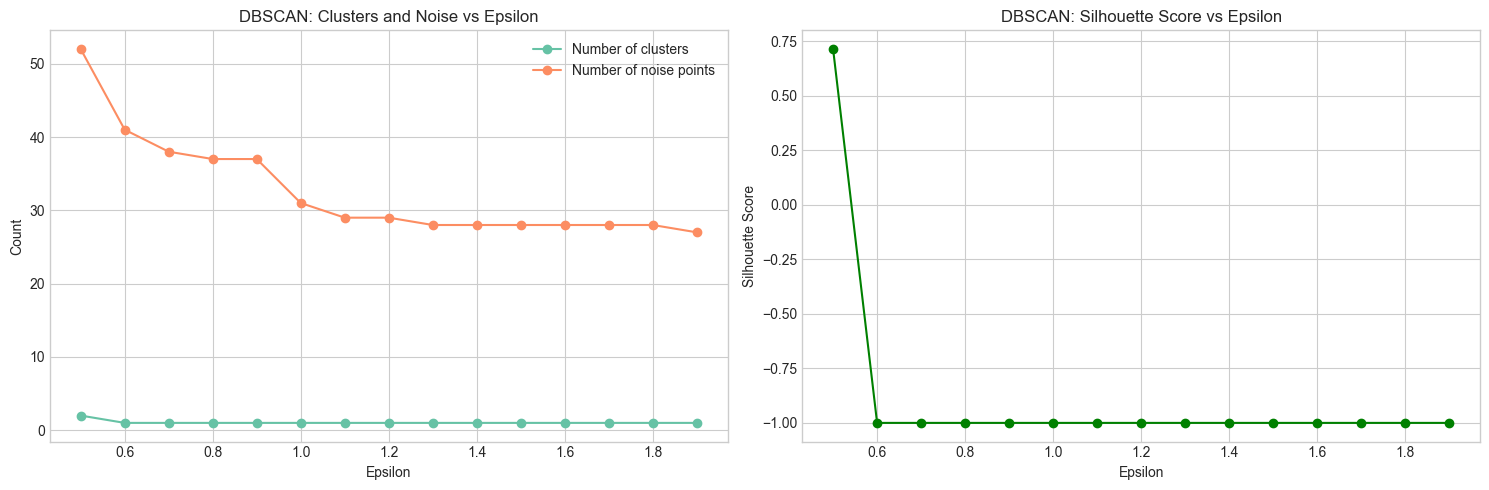

Optimal epsilon: 0.50
DBSCAN Cluster Summary:
         Recency_Mean  Recency_Std  Frequency_Mean  Frequency_Std  \
Cluster                                                             
-1              45.62        91.37           39.25          36.24   
 0              92.93        99.51            3.73           4.14   
 1               2.60         1.34           37.40           1.52   

         Monetary_Mean  Monetary_Std  Count  Percentage  
Cluster                                                  
-1            43070.66      47563.06     52        1.33  
 0             1302.18       1929.66   3864       98.55  
 1             7421.23       1591.77      5        0.13  


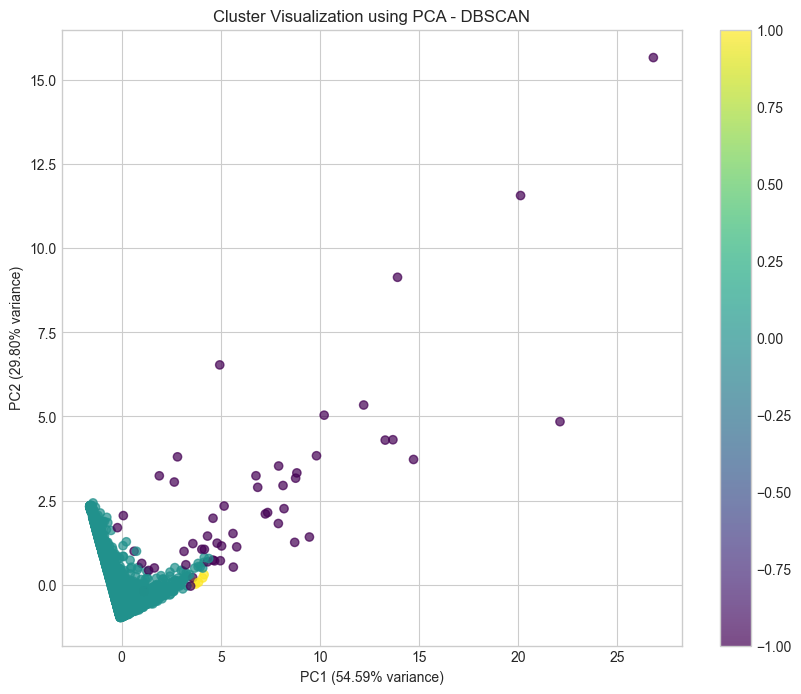

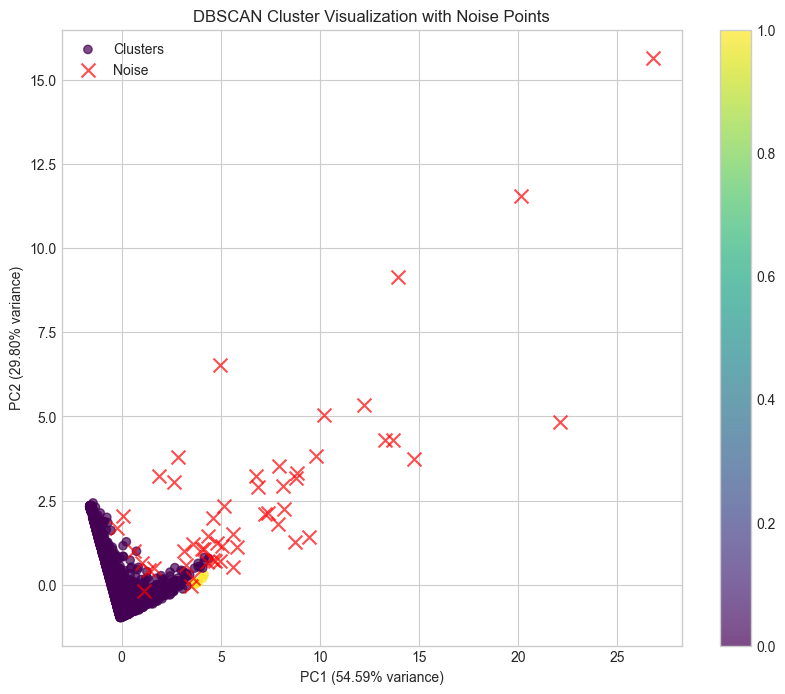

In [8]:
# DBSCAN Clustering
def dbscan_analysis(rfm_scaled, eps_range=np.arange(0.5, 2.0, 0.1), min_samples=5):
    n_clusters = []
    n_noise = []
    silhouette_scores = []
    
    for eps in eps_range:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(rfm_scaled)
        
        # Count clusters and noise points
        n_clusters.append(len(set(labels)) - (1 if -1 in labels else 0))
        n_noise.append(list(labels).count(-1))
        
        # Calculate silhouette score (excluding noise points)
        if len(set(labels)) > 1 and -1 in labels:
            # Filter out noise points for silhouette score calculation
            filtered_labels = labels[labels != -1]
            filtered_data = rfm_scaled[labels != -1]
            if len(set(filtered_labels)) > 1:
                silhouette_scores.append(silhouette_score(filtered_data, filtered_labels))
            else:
                silhouette_scores.append(-1)
        elif len(set(labels)) > 1:
            silhouette_scores.append(silhouette_score(rfm_scaled, labels))
        else:
            silhouette_scores.append(-1)
    
    # Plot results
    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
    # Number of clusters and noise points
    axes[0].plot(eps_range, n_clusters, 'o-', label='Number of clusters')
    axes[0].plot(eps_range, n_noise, 'o-', label='Number of noise points')
    axes[0].set_xlabel('Epsilon')
    axes[0].set_ylabel('Count')
    axes[0].set_title('DBSCAN: Clusters and Noise vs Epsilon')
    axes[0].legend()
    axes[0].grid(True)
    
    # Silhouette score
    axes[1].plot(eps_range, silhouette_scores, 'o-', color='green')
    axes[1].set_xlabel('Epsilon')
    axes[1].set_ylabel('Silhouette Score')
    axes[1].set_title('DBSCAN: Silhouette Score vs Epsilon')
    axes[1].grid(True)
    
    plt.tight_layout()
    plt.savefig('dbscan_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Find optimal epsilon (maximizing silhouette score)
    optimal_eps = eps_range[np.argmax(silhouette_scores)]
    print(f"Optimal epsilon: {optimal_eps:.2f}")
    
    return optimal_eps

# Analyze DBSCAN parameters
optimal_eps = dbscan_analysis(rfm_scaled)

# Apply DBSCAN with optimal parameters
dbscan = DBSCAN(eps=optimal_eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(rfm_scaled)

# Add cluster labels to the original RFM data
rfm_dbscan = rfm.copy()
rfm_dbscan['Cluster'] = dbscan_labels

# Get cluster summary for DBSCAN
dbscan_summary = analyze_clusters(rfm_dbscan)
print("DBSCAN Cluster Summary:")
print(dbscan_summary)

# Visualize DBSCAN clusters
pca_dbscan = plot_clusters_pca(rfm_scaled, dbscan_labels, "DBSCAN")

# Highlight noise points in DBSCAN
def plot_dbscan_noise(rfm_scaled, labels):
    # Apply PCA for visualization
    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(rfm_scaled)
    
    # Create a DataFrame for plotting
    plot_df = pd.DataFrame({
        'PC1': pca_result[:, 0],
        'PC2': pca_result[:, 1],
        'Cluster': labels,
        'Noise': labels == -1
    })
    
    plt.figure(figsize=(10, 8))
    
    # Plot regular clusters
    regular_clusters = plot_df[~plot_df['Noise']]
    scatter1 = plt.scatter(regular_clusters['PC1'], regular_clusters['PC2'], 
                          c=regular_clusters['Cluster'], cmap='viridis', alpha=0.7, 
                          label='Clusters')
    
    # Plot noise points
    noise_points = plot_df[plot_df['Noise']]
    scatter2 = plt.scatter(noise_points['PC1'], noise_points['PC2'], 
                          c='red', alpha=0.7, marker='x', s=100, label='Noise')
    
    plt.colorbar(scatter1)
    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    plt.title('DBSCAN Cluster Visualization with Noise Points')
    plt.legend()
    plt.savefig('dbscan_noise.png', dpi=300, bbox_inches='tight')
    plt.show()

# Plot DBSCAN with noise points highlighted
plot_dbscan_noise(rfm_scaled, dbscan_labels)

### Part 03: Clustering evaluation

In [9]:
# Evaluate clustering results
def evaluate_clustering(rfm_scaled, labels, algorithm_name):
    # Check if there are noise points (for DBSCAN)
    if -1 in labels:
        # Filter out noise points for evaluation
        filtered_labels = labels[labels != -1]
        filtered_data = rfm_scaled[labels != -1]
        n_noise = sum(labels == -1)
        
        if len(set(filtered_labels)) > 1:
            silhouette = silhouette_score(filtered_data, filtered_labels)
        else:
            silhouette = -1
    else:
        silhouette = silhouette_score(rfm_scaled, labels)
        n_noise = 0
    
    # Calculate inter-cluster and intra-cluster distances
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    
    print(f"=== {algorithm_name} Evaluation ===")
    print(f"Number of clusters: {n_clusters}")
    print(f"Number of noise points: {n_noise}")
    print(f"Silhouette Score: {silhouette:.4f}")
    print()
    
    return {
        'algorithm': algorithm_name,
        'n_clusters': n_clusters,
        'n_noise': n_noise,
        'silhouette': silhouette
    }

# Evaluate all clustering algorithms
kmeans_eval = evaluate_clustering(rfm_scaled, kmeans_labels, "K-Means")
agg_eval = evaluate_clustering(rfm_scaled, agg_labels, "Agglomerative Clustering")
dbscan_eval = evaluate_clustering(rfm_scaled, dbscan_labels, "DBSCAN")

# Compare algorithms
eval_df = pd.DataFrame([kmeans_eval, agg_eval, dbscan_eval])
print("Clustering Algorithms Comparison:")
print(eval_df)

# Interpret clusters for each algorithm
def interpret_clusters(rfm_with_clusters, algorithm_name):
    cluster_means = rfm_with_clusters.groupby('Cluster').mean()
    
    print(f"=== {algorithm_name} Cluster Interpretation ===")
    
    for cluster_id in cluster_means.index:
        recency = cluster_means.loc[cluster_id, 'Recency']
        frequency = cluster_means.loc[cluster_id, 'Frequency']
        monetary = cluster_means.loc[cluster_id, 'Monetary']
        
        # Interpret based on RFM values
        if recency < cluster_means['Recency'].median():
            recency_desc = "recent"
        else:
            recency_desc = "not recent"
            
        if frequency > cluster_means['Frequency'].median():
            frequency_desc = "frequent"
        else:
            frequency_desc = "infrequent"
            
        if monetary > cluster_means['Monetary'].median():
            monetary_desc = "high-value"
        else:
            monetary_desc = "low-value"
        
        print(f"Cluster {cluster_id}: {recency_desc}, {frequency_desc}, {monetary_desc} customers")
    
    print()

# Interpret clusters for each algorithm
interpret_clusters(rfm_kmeans, "K-Means")
interpret_clusters(rfm_agg, "Agglomerative Clustering")

# For DBSCAN, exclude noise points (-1)
if -1 in rfm_dbscan['Cluster'].values:
    interpret_clusters(rfm_dbscan[rfm_dbscan['Cluster'] != -1], "DBSCAN (excluding noise)")
else:
    interpret_clusters(rfm_dbscan, "DBSCAN")

=== K-Means Evaluation ===
Number of clusters: 3
Number of noise points: 0
Silhouette Score: 0.5807

=== Agglomerative Clustering Evaluation ===
Number of clusters: 3
Number of noise points: 0
Silhouette Score: 0.6020

=== DBSCAN Evaluation ===
Number of clusters: 2
Number of noise points: 52
Silhouette Score: 0.7132

Clustering Algorithms Comparison:
                  algorithm  n_clusters  n_noise  silhouette
0                   K-Means           3        0    0.580744
1  Agglomerative Clustering           3        0    0.602031
2                    DBSCAN           2       52    0.713169
=== K-Means Cluster Interpretation ===
Cluster 0: not recent, infrequent, low-value customers
Cluster 1: not recent, infrequent, low-value customers
Cluster 2: recent, frequent, high-value customers

=== Agglomerative Clustering Cluster Interpretation ===
Cluster 0: recent, frequent, high-value customers
Cluster 1: not recent, infrequent, low-value customers
Cluster 2: not recent, infrequent, low-va